https://www.kaggle.com/godeep48/unet-with-residual-encoders/notebook#Data-Pipeline

## **Unziping Dataset**

In [ ]:
# !unzip /content/drive/MyDrive/carvana2/data.zip -d /content/drive/MyDrive/carvana6

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
%cd /content/drive/MyDrive/carvana6

/content/drive/MyDrive/carvana6


## **Downloading and Importing all Lib**

In [ ]:
import os
import albumentations
import time
import torch.utils.data as data
import glob
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torchvision
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
#import tqdm as tqdm
from tqdm import tqdm as tqdm

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
import cv2

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random
import imageio

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

: 

## **Split Train and Test set**

In [6]:
# val_images, val_masks

import shutil
import os
import random

# images = os.listdir('/content/drive/MyDrive/carvana6/data/images')
# masks = os.listdir('/content/drive/MyDrive/carvana6/data/masks')
# len(images), len(masks)


# def val_data():
train_images = '/content/drive/MyDrive/carvana6/data/images/'
train_masks = '/content/drive/MyDrive/carvana6/data/masks/'

val_images = '/content/drive/MyDrive/carvana6/test_data/images/'
val_masks = '/content/drive/MyDrive/carvana6/test_data/masks/'



# print(images[:5])
# print(masks[:5])

# print('_____________________________________')

images = os.listdir(train_images)
masks = os.listdir(train_masks)

images.sort()
masks.sort()

for i in range(50):
  x=random.randint(0, 1000-i)
  image=images[x]
  mask=masks[x]
  # print('train_images: ', train_images+image)
  # print('val_images: ', val_images+image)
  # print('train_masks: ', train_masks+mask)
  # print('val_masks: ', val_masks+mask)
  # print('_____________________________________-')
  shutil.move(train_images+image, val_images+image)
  shutil.move(train_masks+mask, val_masks+mask)
  # if i == 5:
  #   break


In [7]:
len(os.listdir('/content/drive/MyDrive/carvana6/data/images')), len(os.listdir('/content/drive/MyDrive/carvana6/data/masks')), len(os.listdir('/content/drive/MyDrive/carvana6/test_data/images')), len(os.listdir('/content/drive/MyDrive/carvana6/test_data/masks'))

(950, 950, 50, 50)

## **Data Pipeline**

In [3]:
def get_train_transform():
   return A.Compose(
       [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        ToTensor()
        ])

class DataLoaderSegmentation(data.Dataset):
  def __init__(self, folder_path, transform=None):
    super(DataLoaderSegmentation, self).__init__()
    self.img_files = glob.glob(os.path.join(folder_path,'images','*.jpg'))
    print(self.img_files)
    self.mask_files = []
    for img_path in self.img_files:
      self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path.split('.')[0]+'_mask.jpg')))
    self.transforms = get_train_transform() 

  
  def __getitem__(self, index):
    img_path = self.img_files[index]
    mask_path = self.mask_files[index]
    data = imageio.imread(img_path)
    label = imageio.imread(mask_path)

    augmented = self.transforms(image=data, mask=label)
    img = augmented['image']
    mask = augmented['mask']
    # mask = mask[0].permute(2, 0, 1)
    return (img,mask)
    # return torch.from_numpy(data).float(), torch.from_numpy(label).float()

  
  def __len__(self):
    if len(self.img_files) == len(self.mask_files):
      return len(self.img_files)

  def name(self, index):
    return self.img_files[index], self.mask_files[index]

    

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/carvana6/data'
train_dataset = DataLoaderSegmentation(TRAIN_PATH, transform=get_train_transform())

In [44]:
image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [45]:
train_dataset.__len__()

950

In [46]:
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [47]:
image

tensor([[[ 1.2043,  1.3584,  1.7180,  ...,  0.9474,  1.8893,  1.3413],
         [ 1.3584,  2.0092,  1.5982,  ...,  0.9988,  1.2557,  1.0844],
         [ 1.2557,  1.6838,  1.8037,  ...,  0.8789,  0.3652,  0.8276],
         ...,
         [ 0.3652,  1.2043,  1.1015,  ...,  0.4337, -0.2342,  0.7933],
         [ 0.4508,  1.0844,  0.7077,  ...,  0.0741, -0.5767,  0.7248],
         [ 0.3994,  0.9817,  0.9817,  ...,  0.6049, -0.0287,  0.7077]],

        [[ 1.5357,  1.6933,  2.0434,  ...,  0.9055,  1.8859,  1.3431],
         [ 1.6933,  2.3410,  1.9209,  ...,  0.9580,  1.2206,  1.0805],
         [ 1.5707,  2.0084,  2.1310,  ...,  0.8880,  0.3627,  0.8704],
         ...,
         [ 0.5203,  1.3782,  1.2731,  ...,  0.7304,  0.2227,  1.4307],
         [ 0.6254,  1.2556,  0.8704,  ...,  0.2402, -0.2150,  1.2906],
         [ 0.5378,  1.1506,  1.1506,  ...,  0.6954,  0.2577,  1.2206]],

        [[ 0.7054,  0.8622,  1.3154,  ...,  1.2282,  2.1520,  1.4374],
         [ 0.8797,  1.5245,  1.1585,  ...,  1

In [48]:
def format_image(img):
    """
    Function to de-standardize the image
    arg: Input Image
    returns: De-standardized image
    """
    img = np.array(np.transpose(img, (1,2,0)))
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    """
    Function to reshape the mask
    """
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

In [49]:
def visualize_dataset(n_images, predict=None):
  """
  Function to visualize images and masks
  """
  maxRange = train_dataset.__len__()
  images = random.sample(range(0, maxRange), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = train_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
    ax[i, 0].set_title("Ground Truth Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()

[509, 91, 342]


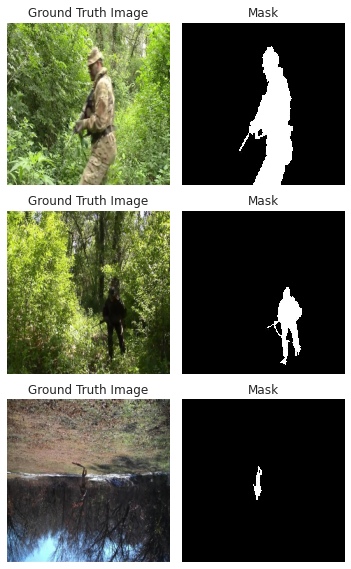

In [50]:
visualize_dataset(3)

In [51]:
## Split train and validation set.
train_data, valid_data = random_split(train_dataset, [900, 50])

train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

val_loader = DataLoader(dataset=valid_data, batch_size=10)

## **Defining Model**

In [52]:
# Model

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class ResUnet(nn.Module):
    def __init__(self, channel, filters=[16, 32, 64, 128, 256, 512, 1024]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)
        self.residual_conv_3 = ResidualConv(filters[2], filters[3], 2, 1)
        self.residual_conv_4 = ResidualConv(filters[3], filters[4], 2, 1)
        self.residual_conv_5 = ResidualConv(filters[4], filters[5], 2, 1)

        self.bridge = ResidualConv(filters[5], filters[6], 2, 1)

        self.upsample_1 = Upsample(filters[6], filters[6], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[6] + filters[5], filters[5], 1, 1)

        self.upsample_2 = Upsample(filters[5], filters[5], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[5] + filters[4], filters[4], 1, 1)

        self.upsample_3 = Upsample(filters[4], filters[4], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[4] + filters[3], filters[3], 1, 1)

        self.upsample_4 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv4 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_5 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv5 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_6 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv6 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        x4 = self.residual_conv_3(x3)
        x5 = self.residual_conv_4(x4)
        x6 = self.residual_conv_5(x5)
        # Bridge
        x7 = self.bridge(x6)
        # Decode
        x7 = self.upsample_1(x7)
        x8 = torch.cat([x7, x6], dim=1)

        x9 = self.up_residual_conv1(x8)
        
        x9 = self.upsample_2(x9)
        x10 = torch.cat([x9, x5], dim=1)

        x11 = self.up_residual_conv2(x10)
        
        x11 = self.upsample_3(x11)
        x12 = torch.cat([x11, x4], dim=1)

        x13 = self.up_residual_conv3(x12)

        x13 = self.upsample_4(x13)
        x14 = torch.cat([x13, x3], dim=1)

        x15 = self.up_residual_conv4(x14)

        x15 = self.upsample_5(x15)
        x16 = torch.cat([x15, x2], dim=1)

        x17 = self.up_residual_conv5(x16)

        x17 = self.upsample_6(x17)
        x18 = torch.cat([x17, x1], dim=1)

        x19 = self.up_residual_conv6(x18)

        output = self.output_layer(x19)

        return output

In [53]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [54]:
model = ResUnet(3).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [55]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [17]:
# Creating model weight directory
weight_path = "model_weight"
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

## **Model Training**

In [56]:
#from engine import evaluate
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs=180
valid_loss_min = np.Inf

checkpoint_path = 'model_weight/chkpoint_'
best_model_path = 'model_weight/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
  
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      #Loss
      loss = criterion(output, y_train)
      losses_value = loss.item()
      #Score
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      #train_score.append(score)
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## Compute Loss Value.
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## Compute Accuracy Score
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    #Save best model Checkpoint
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    ## TODO: save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

Epoch: 1, loss: 0.9061376452445984, IoU: 0.04926140606403351: 100%|██████████| 90/90 [00:50<00:00,  1.79it/s]



###############Train Loss: 0.7480542633268569, Train IOU: 0.1521272742913829###############
###############Valid Loss: 0.5880349993705749, Valid IOU: 0.27421789765357973###############
Validation loss decreased (inf --> 0.588035).  Saving model ...


Epoch: 2, loss: 0.4044651389122009, IoU: 0.42404741048812866: 100%|██████████| 90/90 [00:51<00:00,  1.76it/s]



###############Train Loss: 0.5647550655735863, Train IOU: 0.28935531626145045###############
###############Valid Loss: 0.505463695526123, Valid IOU: 0.33841672539711###############
Validation loss decreased (0.588035 --> 0.505464).  Saving model ...


Epoch: 3, loss: 0.38438117504119873, IoU: 0.4447039067745209: 100%|██████████| 90/90 [00:51<00:00,  1.75it/s]



###############Train Loss: 0.5260884039931827, Train IOU: 0.32226337132354577###############
###############Valid Loss: 0.5225747227668762, Valid IOU: 0.3222854197025299###############


Epoch: 4, loss: 0.3677988648414612, IoU: 0.4622196853160858: 100%|██████████| 90/90 [00:51<00:00,  1.73it/s]



###############Train Loss: 0.5179127289189233, Train IOU: 0.32882835475417477###############
###############Valid Loss: 0.4389201045036316, Valid IOU: 0.40937813818454744###############
Validation loss decreased (0.505464 --> 0.438920).  Saving model ...


Epoch: 5, loss: 0.7187706828117371, IoU: 0.16364675760269165: 100%|██████████| 90/90 [00:51<00:00,  1.73it/s]



###############Train Loss: 0.4725062820646498, Train IOU: 0.3703165059288343###############
###############Valid Loss: 0.43037848472595214, Valid IOU: 0.4127379596233368###############
Validation loss decreased (0.438920 --> 0.430378).  Saving model ...


Epoch: 6, loss: 0.40843385457992554, IoU: 0.42002779245376587: 100%|██████████| 90/90 [00:52<00:00,  1.72it/s]



###############Train Loss: 0.45431640876664053, Train IOU: 0.3849104223979844###############
###############Valid Loss: 0.44959700107574463, Valid IOU: 0.3990991860628128###############


Epoch: 7, loss: 0.4682046175003052, IoU: 0.3622293174266815: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.45609496235847474, Train IOU: 0.38396295805772146###############
###############Valid Loss: 0.4953176498413086, Valid IOU: 0.3626179829239845###############


Epoch: 8, loss: 0.2805643677711487, IoU: 0.5618236064910889: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.4367354114850362, Train IOU: 0.4038145071930356###############
###############Valid Loss: 0.41275930404663086, Valid IOU: 0.43227254748344424###############
Validation loss decreased (0.430378 --> 0.412759).  Saving model ...


Epoch: 9, loss: 0.29301148653030396, IoU: 0.5468030571937561: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.38474731842676796, Train IOU: 0.45423814372883903###############
###############Valid Loss: 0.4346832513809204, Valid IOU: 0.4171654596924782###############


Epoch: 10, loss: 0.23839080333709717, IoU: 0.6150050163269043: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.4027219076951345, Train IOU: 0.4359418319331275###############
###############Valid Loss: 0.3357232570648193, Valid IOU: 0.5067700505256653###############
Validation loss decreased (0.412759 --> 0.335723).  Saving model ...


Epoch: 11, loss: 0.41666603088378906, IoU: 0.4117857813835144: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.38402260541915895, Train IOU: 0.45456298672490647###############
###############Valid Loss: 0.3977244019508362, Valid IOU: 0.4480859816074371###############


Epoch: 12, loss: 0.4254792332649231, IoU: 0.4030545651912689: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.3792402320437961, Train IOU: 0.45966233213742574###############
###############Valid Loss: 0.3782365798950195, Valid IOU: 0.4688741654157639###############


Epoch: 13, loss: 0.33434462547302246, IoU: 0.4988766014575958: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.38960910704400803, Train IOU: 0.44798358380794523###############
###############Valid Loss: 0.3557034730911255, Valid IOU: 0.4877741992473602###############


Epoch: 14, loss: 0.36783725023269653, IoU: 0.46218010783195496: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.35795812010765077, Train IOU: 0.4835994379387962###############
###############Valid Loss: 0.39796589612960814, Valid IOU: 0.441754549741745###############


Epoch: 15, loss: 0.2187291979789734, IoU: 0.6410658359527588: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.3528774956862132, Train IOU: 0.4893726709816191###############
###############Valid Loss: 0.34622280597686766, Valid IOU: 0.49968004822731016###############


Epoch: 16, loss: 0.36160266399383545, IoU: 0.4688681960105896: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.3414564026726617, Train IOU: 0.5014025040798717###############
###############Valid Loss: 0.30950536727905276, Valid IOU: 0.5395015776157379###############
Validation loss decreased (0.335723 --> 0.309505).  Saving model ...


Epoch: 17, loss: 0.2740195393562317, IoU: 0.5698471665382385: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.33568799297014873, Train IOU: 0.5059945969118013###############
###############Valid Loss: 0.40282984972000124, Valid IOU: 0.44369220435619355###############


Epoch: 18, loss: 0.40627050399780273, IoU: 0.42223209142684937: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.3295702172650231, Train IOU: 0.5132129117846489###############
###############Valid Loss: 0.34230583906173706, Valid IOU: 0.5019211530685425###############


Epoch: 19, loss: 0.35015517473220825, IoU: 0.48133713006973267: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.34509483774503075, Train IOU: 0.49475570304526223###############
###############Valid Loss: 0.34680403470993043, Valid IOU: 0.49981417655944826###############


Epoch: 20, loss: 0.2664436101913452, IoU: 0.5792356133460999: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.3938571545812819, Train IOU: 0.45101589808861414###############
###############Valid Loss: 0.3044366240501404, Valid IOU: 0.5426819562911988###############
Validation loss decreased (0.309505 --> 0.304437).  Saving model ...


Epoch: 21, loss: 0.5023916363716125, IoU: 0.33122289180755615: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.3308519111739265, Train IOU: 0.5135033072696792###############
###############Valid Loss: 0.3940229296684265, Valid IOU: 0.4424493372440338###############


Epoch: 22, loss: 0.4257259964942932, IoU: 0.4028065800666809: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.3135882192187839, Train IOU: 0.5317298058006499###############
###############Valid Loss: 0.3671965360641479, Valid IOU: 0.48347571194171907###############


Epoch: 23, loss: 0.29270488023757935, IoU: 0.547157347202301: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.30642289453082616, Train IOU: 0.5401948872539732###############
###############Valid Loss: 0.3584566473960876, Valid IOU: 0.47944952845573424###############


Epoch: 24, loss: 0.18401944637298584, IoU: 0.6891714930534363: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.3017583025826348, Train IOU: 0.548627795279026###############
###############Valid Loss: 0.31289502382278445, Valid IOU: 0.5334279537200928###############


Epoch: 25, loss: 0.2720720171928406, IoU: 0.5722513198852539: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.29202753239207796, Train IOU: 0.5599649979836411###############
###############Valid Loss: 0.28450788259506227, Valid IOU: 0.5605086147785187###############
Validation loss decreased (0.304437 --> 0.284508).  Saving model ...


Epoch: 26, loss: 0.2708589434623718, IoU: 0.5737480521202087: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.2880619400077396, Train IOU: 0.5638884191711744###############
###############Valid Loss: 0.3498989462852478, Valid IOU: 0.49720373153686526###############


Epoch: 27, loss: 0.25180578231811523, IoU: 0.5977111458778381: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.28839834994739955, Train IOU: 0.5625245304571258###############
###############Valid Loss: 0.311802065372467, Valid IOU: 0.5380527794361114###############


Epoch: 28, loss: 0.23304378986358643, IoU: 0.6220133304595947: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.2702106614907583, Train IOU: 0.583501234319475###############
###############Valid Loss: 0.31970258951187136, Valid IOU: 0.530899041891098###############


Epoch: 29, loss: 0.1426035761833191, IoU: 0.7503963112831116: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.2488112231095632, Train IOU: 0.6072362244129181###############
###############Valid Loss: 0.31184401512146, Valid IOU: 0.5404240906238555###############


Epoch: 30, loss: 0.40652626752853394, IoU: 0.4219707250595093: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.2597855528195699, Train IOU: 0.5965022477838728###############
###############Valid Loss: 0.3065730810165405, Valid IOU: 0.5474088847637176###############


Epoch: 31, loss: 0.49765247106552124, IoU: 0.33545777201652527: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.2628400637043847, Train IOU: 0.5915002298023966###############
###############Valid Loss: 0.3108464241027832, Valid IOU: 0.5439153552055359###############


Epoch: 32, loss: 0.6150155067443848, IoU: 0.23841623961925507: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.26731331480873954, Train IOU: 0.5874148728119002###############
###############Valid Loss: 0.27513842582702636, Valid IOU: 0.573993182182312###############
Validation loss decreased (0.284508 --> 0.275138).  Saving model ...


Epoch: 33, loss: 0.11112779378890991, IoU: 0.7999790906906128: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.27363649805386864, Train IOU: 0.5788094431161881###############
###############Valid Loss: 0.30017322301864624, Valid IOU: 0.5484445631504059###############


Epoch: 34, loss: 0.22905677556991577, IoU: 0.6272759437561035: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.24345997969309488, Train IOU: 0.6147784666882621###############
###############Valid Loss: 0.32673354148864747, Valid IOU: 0.5330392897129059###############


Epoch: 35, loss: 0.4961780905723572, IoU: 0.33679771423339844: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.2453879819975959, Train IOU: 0.6131864978207482###############
###############Valid Loss: 0.33479965925216676, Valid IOU: 0.5178209900856018###############


Epoch: 36, loss: 0.29141712188720703, IoU: 0.5487130284309387: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.23545915418201022, Train IOU: 0.6258159541421466###############
###############Valid Loss: 0.28242456912994385, Valid IOU: 0.5771861433982849###############


Epoch: 37, loss: 0.24719947576522827, IoU: 0.6036053895950317: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.2469291845957438, Train IOU: 0.611725613143709###############
###############Valid Loss: 0.3080979108810425, Valid IOU: 0.5438199996948242###############


Epoch: 38, loss: 0.24794727563858032, IoU: 0.6026480197906494: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.2397867096794976, Train IOU: 0.6211976375844743###############
###############Valid Loss: 0.284212327003479, Valid IOU: 0.5744555950164795###############


Epoch: 39, loss: 0.27887654304504395, IoU: 0.5638845562934875: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.2337730520301395, Train IOU: 0.6278940892881817###############
###############Valid Loss: 0.3153141736984253, Valid IOU: 0.5366597533226013###############


Epoch: 40, loss: 0.22449088096618652, IoU: 0.6333473324775696: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.24098296695285373, Train IOU: 0.6176608122057385###############
###############Valid Loss: 0.30274651050567625, Valid IOU: 0.5495999693870545###############


Epoch: 41, loss: 0.20068573951721191, IoU: 0.6657291650772095: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.22639037171999613, Train IOU: 0.6394361787372165###############
###############Valid Loss: 0.3022549867630005, Valid IOU: 0.549048227071762###############


Epoch: 42, loss: 0.2754404544830322, IoU: 0.5681108832359314: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.22031538751390245, Train IOU: 0.6449210902055105###############
###############Valid Loss: 0.2918142557144165, Valid IOU: 0.561102294921875###############


Epoch: 43, loss: 0.2641390562057495, IoU: 0.582116425037384: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.23043346405029297, Train IOU: 0.6327980054749383###############
###############Valid Loss: 0.29765676259994506, Valid IOU: 0.559282261133194###############


Epoch: 44, loss: 0.2802848219871521, IoU: 0.5621713399887085: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.22624846696853637, Train IOU: 0.6400045391586092###############
###############Valid Loss: 0.27552937269210814, Valid IOU: 0.5793585658073426###############


Epoch: 45, loss: 0.33220547437667847, IoU: 0.5012996792793274: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.23172059257825214, Train IOU: 0.6303510076469845###############
###############Valid Loss: 0.32385005950927737, Valid IOU: 0.5319628596305848###############


Epoch: 46, loss: 0.20470643043518066, IoU: 0.6601658463478088: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.24578639732466803, Train IOU: 0.6139683759874768###############
###############Valid Loss: 0.29160231351852417, Valid IOU: 0.5629201591014862###############


Epoch: 47, loss: 0.21276575326919556, IoU: 0.6491395831108093: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.24388560851414998, Train IOU: 0.6163543297184838###############
###############Valid Loss: 0.28065640926361085, Valid IOU: 0.5711238622665405###############


Epoch: 48, loss: 0.2023789882659912, IoU: 0.6633785963058472: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.22261689901351928, Train IOU: 0.6445900244845284###############
###############Valid Loss: 0.2505201458930969, Valid IOU: 0.6111524879932404###############
Validation loss decreased (0.275138 --> 0.250520).  Saving model ...


Epoch: 49, loss: 0.2016804814338684, IoU: 0.6643556952476501: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.2010027077462938, Train IOU: 0.6705851283338334###############
###############Valid Loss: 0.3340390682220459, Valid IOU: 0.5209280908107757###############


Epoch: 50, loss: 0.18933337926864624, IoU: 0.6816219091415405: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.20528633462058174, Train IOU: 0.6653004440996382###############
###############Valid Loss: 0.2794260621070862, Valid IOU: 0.5804475784301758###############


Epoch: 51, loss: 0.24244391918182373, IoU: 0.6097548604011536: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.24124726388189527, Train IOU: 0.6215579455097516###############
###############Valid Loss: 0.31230869293212893, Valid IOU: 0.54252969622612###############


Epoch: 52, loss: 0.41990435123443604, IoU: 0.40858104825019836: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.22164941761228774, Train IOU: 0.6449195795589023###############
###############Valid Loss: 0.3105535387992859, Valid IOU: 0.5441867768764496###############


Epoch: 53, loss: 0.26764577627182007, IoU: 0.5777369737625122: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.20915089315838284, Train IOU: 0.6601556440194448###############
###############Valid Loss: 0.2775832056999207, Valid IOU: 0.5797625362873078###############


Epoch: 54, loss: 0.18264716863632202, IoU: 0.6911270022392273: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1956714822186364, Train IOU: 0.678107640478346###############
###############Valid Loss: 0.27273461818695066, Valid IOU: 0.5880401134490967###############


Epoch: 55, loss: 0.22898149490356445, IoU: 0.6273812055587769: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.1869656629032559, Train IOU: 0.6904866284794278###############
###############Valid Loss: 0.2726276397705078, Valid IOU: 0.5908980906009674###############


Epoch: 56, loss: 0.17408031225204468, IoU: 0.7034727931022644: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.18498438199361164, Train IOU: 0.6936304406987296###############
###############Valid Loss: 0.2629145383834839, Valid IOU: 0.6008232712745667###############


Epoch: 57, loss: 0.09541434049606323, IoU: 0.8257983922958374: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.19337271319495308, Train IOU: 0.6819133341312409###############
###############Valid Loss: 0.2696140885353088, Valid IOU: 0.5894727766513824###############


Epoch: 58, loss: 0.17602789402008057, IoU: 0.7006515860557556: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1952950696150462, Train IOU: 0.6779271725151274###############
###############Valid Loss: 0.25437135696411134, Valid IOU: 0.6077407419681549###############


Epoch: 59, loss: 0.12707412242889404, IoU: 0.7745130658149719: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.2048130604955885, Train IOU: 0.6682799253198836###############
###############Valid Loss: 0.30247840881347654, Valid IOU: 0.5632687032222747###############


Epoch: 60, loss: 0.14474910497665405, IoU: 0.7471195459365845: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.18480621774991354, Train IOU: 0.6916314777400758###############
###############Valid Loss: 0.2724601626396179, Valid IOU: 0.5912789583206177###############


Epoch: 61, loss: 0.27948564291000366, IoU: 0.5631554126739502: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.20128189192877877, Train IOU: 0.6724869340658188###############
###############Valid Loss: 0.2509117007255554, Valid IOU: 0.611672431230545###############


Epoch: 62, loss: 0.1850423812866211, IoU: 0.687714695930481: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.1904565903875563, Train IOU: 0.6860626002152761###############
###############Valid Loss: 0.2716641306877136, Valid IOU: 0.5918820023536682###############


Epoch: 63, loss: 0.42148447036743164, IoU: 0.40701770782470703: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.20162366761101616, Train IOU: 0.6718446479903327###############
###############Valid Loss: 0.2428613543510437, Valid IOU: 0.6249948561191558###############
Validation loss decreased (0.250520 --> 0.242861).  Saving model ...


Epoch: 64, loss: 0.09844809770584106, IoU: 0.8207541704177856: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.1940723200639089, Train IOU: 0.6796148969067468###############
###############Valid Loss: 0.2662832260131836, Valid IOU: 0.5932037830352783###############


Epoch: 65, loss: 0.10286056995391846, IoU: 0.8134713172912598: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.19546216792530482, Train IOU: 0.6786998715665605###############
###############Valid Loss: 0.2699225306510925, Valid IOU: 0.5903014183044434###############


Epoch: 66, loss: 0.2812724709510803, IoU: 0.560981035232544: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.18651508887608845, Train IOU: 0.6916211783885956###############
###############Valid Loss: 0.25614596605300904, Valid IOU: 0.6071351528167724###############


Epoch: 67, loss: 0.16026049852371216, IoU: 0.7237587571144104: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.1835904750559065, Train IOU: 0.6942840857638253###############
###############Valid Loss: 0.3289617896080017, Valid IOU: 0.5248181283473968###############


Epoch: 68, loss: 0.18986833095550537, IoU: 0.6808693408966064: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.2357736693488227, Train IOU: 0.6252143465810351###############
###############Valid Loss: 0.3446130871772766, Valid IOU: 0.5055583089590072###############


Epoch: 69, loss: 0.10361224412918091, IoU: 0.8122371435165405: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.22674206495285035, Train IOU: 0.6379431171549691###############
###############Valid Loss: 0.22434852123260499, Valid IOU: 0.636940062046051###############
Validation loss decreased (0.242861 --> 0.224349).  Saving model ...


Epoch: 70, loss: 0.22631162405014038, IoU: 0.630926251411438: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.18114988406499227, Train IOU: 0.6974801275465223###############
###############Valid Loss: 0.2580463409423828, Valid IOU: 0.6025725781917572###############


Epoch: 71, loss: 0.17096537351608276, IoU: 0.7080076336860657: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.19541695051723057, Train IOU: 0.6812563473979633###############
###############Valid Loss: 0.3027503490447998, Valid IOU: 0.5514247477054596###############


Epoch: 72, loss: 0.17065656185150146, IoU: 0.7084581851959229: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.18318415217929415, Train IOU: 0.6947027166684469###############
###############Valid Loss: 0.24465969800949097, Valid IOU: 0.6219695985317231###############


Epoch: 73, loss: 0.14626151323318481, IoU: 0.7448127865791321: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.19201116959253947, Train IOU: 0.6852890527910657###############
###############Valid Loss: 0.26730082035064695, Valid IOU: 0.59354487657547###############


Epoch: 74, loss: 0.13134896755218506, IoU: 0.7678061723709106: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.18406753208902146, Train IOU: 0.693743012017674###############
###############Valid Loss: 0.25797492265701294, Valid IOU: 0.6084181070327759###############


Epoch: 75, loss: 0.14810031652450562, IoU: 0.7420116066932678: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.17651300960116917, Train IOU: 0.7042332053184509###############
###############Valid Loss: 0.2663676023483276, Valid IOU: 0.6001662492752076###############


Epoch: 76, loss: 0.1354609727859497, IoU: 0.7614086270332336: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.18214307957225376, Train IOU: 0.6978294134140015###############
###############Valid Loss: 0.2426358699798584, Valid IOU: 0.6253256797790527###############


Epoch: 77, loss: 0.2986878752708435, IoU: 0.5400350689888: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.17539624571800233, Train IOU: 0.7068340983655718###############
###############Valid Loss: 0.24070005416870116, Valid IOU: 0.6283848404884338###############


Epoch: 78, loss: 0.16851580142974854, IoU: 0.7115815281867981: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.16430482467015584, Train IOU: 0.7219850791825189###############
###############Valid Loss: 0.268211305141449, Valid IOU: 0.593533843755722###############


Epoch: 79, loss: 0.31114351749420166, IoU: 0.5254144072532654: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.19487535158793132, Train IOU: 0.6815409746434954###############
###############Valid Loss: 0.26745531558990476, Valid IOU: 0.5957954347133636###############


Epoch: 80, loss: 0.28575366735458374, IoU: 0.555528461933136: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.19004619320233662, Train IOU: 0.6868763837549422###############
###############Valid Loss: 0.2605566501617432, Valid IOU: 0.603986257314682###############


Epoch: 81, loss: 0.2137128710746765, IoU: 0.6478460431098938: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.16506888932651945, Train IOU: 0.7205178588628769###############
###############Valid Loss: 0.23578300476074218, Valid IOU: 0.6273951232433319###############


Epoch: 82, loss: 0.19629734754562378, IoU: 0.6718454360961914: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.1637798508008321, Train IOU: 0.7222002661890454###############
###############Valid Loss: 0.1989322304725647, Valid IOU: 0.6727485418319702###############
Validation loss decreased (0.224349 --> 0.198932).  Saving model ...


Epoch: 83, loss: 0.1236041784286499, IoU: 0.7799962162971497: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.16901382274097868, Train IOU: 0.7167546229230033###############
###############Valid Loss: 0.23474353551864624, Valid IOU: 0.6270566821098328###############


Epoch: 84, loss: 0.2078506350517273, IoU: 0.655855119228363: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.18151015440622967, Train IOU: 0.6999702129099105###############
###############Valid Loss: 0.24718453884124755, Valid IOU: 0.6179552495479583###############


Epoch: 85, loss: 0.14426827430725098, IoU: 0.7478511333465576: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.16288300818867155, Train IOU: 0.7243815696901745###############
###############Valid Loss: 0.24741314649581908, Valid IOU: 0.6145679831504822###############


Epoch: 86, loss: 0.21629291772842407, IoU: 0.6443487405776978: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1606399721569485, Train IOU: 0.7272151675489213###############
###############Valid Loss: 0.23342906236648558, Valid IOU: 0.630352258682251###############


Epoch: 87, loss: 0.5440284013748169, IoU: 0.29534709453582764: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.17147480712996588, Train IOU: 0.7133747647205989###############
###############Valid Loss: 0.2576547384262085, Valid IOU: 0.6071377754211426###############


Epoch: 88, loss: 0.1846058964729309, IoU: 0.6883472204208374: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.15389518605338204, Train IOU: 0.7368098205990261###############
###############Valid Loss: 0.26863170862197877, Valid IOU: 0.5882275462150574###############


Epoch: 89, loss: 0.08245384693145752, IoU: 0.8476582765579224: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1597738371955024, Train IOU: 0.7300516575574875###############
###############Valid Loss: 0.23372726440429686, Valid IOU: 0.6338000595569611###############


Epoch: 90, loss: 0.0793944001197815, IoU: 0.85289466381073: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15171491901079814, Train IOU: 0.7397981961568196###############
###############Valid Loss: 0.237565815448761, Valid IOU: 0.6271163940429687###############


Epoch: 91, loss: 0.13824820518493652, IoU: 0.7570951581001282: 100%|██████████| 90/90 [00:53<00:00,  1.68it/s]



###############Train Loss: 0.16347772942648994, Train IOU: 0.7238912741343181###############
###############Valid Loss: 0.20439684391021729, Valid IOU: 0.6646978735923768###############


Epoch: 92, loss: 0.1298079490661621, IoU: 0.7702217102050781: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1553093473116557, Train IOU: 0.735235865910848###############
###############Valid Loss: 0.2180774211883545, Valid IOU: 0.6523329436779022###############


Epoch: 93, loss: 0.15555375814437866, IoU: 0.7307844161987305: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1533203661441803, Train IOU: 0.7373465485042996###############
###############Valid Loss: 0.22163766622543335, Valid IOU: 0.6491724014282226###############


Epoch: 94, loss: 0.08161473274230957, IoU: 0.8490911722183228: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1501122666729821, Train IOU: 0.7422227342923482###############
###############Valid Loss: 0.2461490511894226, Valid IOU: 0.6199050664901733###############


Epoch: 95, loss: 0.14665216207504272, IoU: 0.7442232370376587: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.17057591014438206, Train IOU: 0.7129901124371423###############
###############Valid Loss: 0.2407591700553894, Valid IOU: 0.6275047063827515###############


Epoch: 96, loss: 0.13262110948562622, IoU: 0.7658272385597229: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.16227195395363703, Train IOU: 0.7245173513889313###############
###############Valid Loss: 0.29174883365631105, Valid IOU: 0.5753982603549957###############


Epoch: 97, loss: 0.17490404844284058, IoU: 0.7022779583930969: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15195322699016994, Train IOU: 0.7405102762911054###############
###############Valid Loss: 0.22697556018829346, Valid IOU: 0.6435976207256318###############


Epoch: 98, loss: 0.14234519004821777, IoU: 0.7507892847061157: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15859439704153272, Train IOU: 0.7301714715030458###############
###############Valid Loss: 0.24634137153625488, Valid IOU: 0.6253318727016449###############


Epoch: 99, loss: 0.22506189346313477, IoU: 0.6325821280479431: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.16543293595314026, Train IOU: 0.7219679279459847###############
###############Valid Loss: 0.23767356872558593, Valid IOU: 0.6300044596195221###############


Epoch: 100, loss: 0.2225128412246704, IoU: 0.6359921097755432: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1482194337579939, Train IOU: 0.7452675196859572###############
###############Valid Loss: 0.2447012782096863, Valid IOU: 0.6197602808475494###############


Epoch: 101, loss: 0.09877067804336548, IoU: 0.820220947265625: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15825404193666245, Train IOU: 0.7315527684158749###############
###############Valid Loss: 0.2041005253791809, Valid IOU: 0.6670861601829529###############


Epoch: 102, loss: 0.0902976393699646, IoU: 0.8343649506568909: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.16457458999421862, Train IOU: 0.722034889128473###############
###############Valid Loss: 0.28599507808685304, Valid IOU: 0.5802907139062882###############


Epoch: 103, loss: 0.17729640007019043, IoU: 0.6988233923912048: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1923463437292311, Train IOU: 0.6847996309399604###############
###############Valid Loss: 0.2487317442893982, Valid IOU: 0.6187613785266877###############


Epoch: 104, loss: 0.1959722638130188, IoU: 0.6722896099090576: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.18389809197849696, Train IOU: 0.6952679584423701###############
###############Valid Loss: 0.2824974775314331, Valid IOU: 0.5716524183750152###############


Epoch: 105, loss: 0.2575224041938782, IoU: 0.5904481410980225: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15420637991693284, Train IOU: 0.7368101977639728###############
###############Valid Loss: 0.2336765170097351, Valid IOU: 0.6380858778953552###############


Epoch: 106, loss: 0.11400109529495239, IoU: 0.7953379154205322: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1519446651140849, Train IOU: 0.7408312135272556###############
###############Valid Loss: 0.19459935426712036, Valid IOU: 0.6781542181968689###############
Validation loss decreased (0.198932 --> 0.194599).  Saving model ...


Epoch: 107, loss: 0.12400466203689575, IoU: 0.7793575525283813: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14337348540623981, Train IOU: 0.7520558092329237###############
###############Valid Loss: 0.23726061582565308, Valid IOU: 0.6282736480236053###############


Epoch: 108, loss: 0.22592896223068237, IoU: 0.6314337253570557: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.1560156908300188, Train IOU: 0.7338496413495805###############
###############Valid Loss: 0.26694091558456423, Valid IOU: 0.599262797832489###############


Epoch: 109, loss: 0.24884629249572754, IoU: 0.6015079617500305: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15235051181581286, Train IOU: 0.7401761107974583###############
###############Valid Loss: 0.2645007252693176, Valid IOU: 0.599012166261673###############


Epoch: 110, loss: 0.18459993600845337, IoU: 0.6883468627929688: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14690955215030246, Train IOU: 0.7469677792655097###############
###############Valid Loss: 0.2635395646095276, Valid IOU: 0.6009364306926728###############


Epoch: 111, loss: 0.1566256284713745, IoU: 0.729183554649353: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.14341864387194317, Train IOU: 0.7525778452555338###############
###############Valid Loss: 0.2591148853302002, Valid IOU: 0.6073011517524719###############


Epoch: 112, loss: 0.15246611833572388, IoU: 0.7354223728179932: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.16798352400461833, Train IOU: 0.7180253316958746###############
###############Valid Loss: 0.35025606155395506, Valid IOU: 0.49930652379989626###############


Epoch: 113, loss: 0.12563157081604004, IoU: 0.7767875790596008: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.16711550156275432, Train IOU: 0.7186279177665711###############
###############Valid Loss: 0.2509181022644043, Valid IOU: 0.6161220252513886###############


Epoch: 114, loss: 0.06742602586746216, IoU: 0.8736689686775208: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.14908285008536445, Train IOU: 0.7452922059430016###############
###############Valid Loss: 0.25054976940155027, Valid IOU: 0.6115038216114044###############


Epoch: 115, loss: 0.1906827688217163, IoU: 0.6797300577163696: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.14165589213371277, Train IOU: 0.7553128126594756###############
###############Valid Loss: 0.21863305568695068, Valid IOU: 0.6500772416591645###############


Epoch: 116, loss: 0.11517620086669922, IoU: 0.7934442758560181: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.14505548609627616, Train IOU: 0.75022920899921###############
###############Valid Loss: 0.2625847697257996, Valid IOU: 0.6061486542224884###############


Epoch: 117, loss: 0.14977914094924927, IoU: 0.7394728660583496: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.16778262787395054, Train IOU: 0.7178927703036202###############
###############Valid Loss: 0.25461132526397706, Valid IOU: 0.6110527694225312###############


Epoch: 118, loss: 0.2368336319923401, IoU: 0.6170417666435242: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.16429066724247401, Train IOU: 0.7225062963035371###############
###############Valid Loss: 0.26009747982025144, Valid IOU: 0.598096489906311###############


Epoch: 119, loss: 0.12162953615188599, IoU: 0.7831252813339233: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.19047914875878227, Train IOU: 0.686791585220231###############
###############Valid Loss: 0.23505946397781372, Valid IOU: 0.6272578537464142###############


Epoch: 120, loss: 0.21074211597442627, IoU: 0.6519043445587158: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14573799239264595, Train IOU: 0.7492324348953036###############
###############Valid Loss: 0.20191460847854614, Valid IOU: 0.6681404948234558###############


Epoch: 121, loss: 0.14784538745880127, IoU: 0.7424103617668152: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.13740729888280231, Train IOU: 0.7608570204840766###############
###############Valid Loss: 0.16725685596466064, Valid IOU: 0.7185302615165711###############
Validation loss decreased (0.194599 --> 0.167257).  Saving model ...


Epoch: 122, loss: 0.16605091094970703, IoU: 0.7152056694030762: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.14471152226130168, Train IOU: 0.7515102310313119###############
###############Valid Loss: 0.1930646061897278, Valid IOU: 0.6834372460842133###############


Epoch: 123, loss: 0.11506015062332153, IoU: 0.793630063533783: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.13557018836339316, Train IOU: 0.7637490153312683###############
###############Valid Loss: 0.17143279314041138, Valid IOU: 0.7097294330596924###############


Epoch: 124, loss: 0.1820163130760193, IoU: 0.6920398473739624: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.14086175560951233, Train IOU: 0.7560620811250475###############
###############Valid Loss: 0.18540477752685547, Valid IOU: 0.6895537614822388###############


Epoch: 125, loss: 0.10395258665084839, IoU: 0.8116774559020996: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.1348674025800493, Train IOU: 0.7662076165278753###############
###############Valid Loss: 0.21250617504119873, Valid IOU: 0.657754385471344###############


Epoch: 126, loss: 0.11747115850448608, IoU: 0.789764940738678: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.13213864498668246, Train IOU: 0.7691733837127686###############
###############Valid Loss: 0.17304252386093139, Valid IOU: 0.7090798497200013###############


Epoch: 127, loss: 0.14635461568832397, IoU: 0.7446680068969727: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.14771360556284588, Train IOU: 0.7472131027115716###############
###############Valid Loss: 0.18685368299484253, Valid IOU: 0.6883179903030395###############


Epoch: 128, loss: 0.17317909002304077, IoU: 0.7047888040542603: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.14238490131166245, Train IOU: 0.7535153107510673###############
###############Valid Loss: 0.25977625846862795, Valid IOU: 0.6015353918075561###############


Epoch: 129, loss: 0.09179538488388062, IoU: 0.8318509459495544: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14928880731264751, Train IOU: 0.7448582251866659###############
###############Valid Loss: 0.2576577544212341, Valid IOU: 0.6105054616928101###############


Epoch: 130, loss: 0.17824125289916992, IoU: 0.6974557042121887: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.13074040810267132, Train IOU: 0.7711852331956227###############
###############Valid Loss: 0.1834346890449524, Valid IOU: 0.6929498314857483###############


Epoch: 131, loss: 0.04425269365310669, IoU: 0.9152465462684631: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.13209909134440953, Train IOU: 0.7695977131525675###############
###############Valid Loss: 0.1881041169166565, Valid IOU: 0.6864370346069336###############


Epoch: 132, loss: 0.13551479578018188, IoU: 0.7613218426704407: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.13797809415393406, Train IOU: 0.7609403166506026###############
###############Valid Loss: 0.1771887421607971, Valid IOU: 0.7017161130905152###############


Epoch: 133, loss: 0.08732563257217407, IoU: 0.8393807411193848: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.1340361879931556, Train IOU: 0.7665444675419065###############
###############Valid Loss: 0.19022583961486816, Valid IOU: 0.6862869381904602###############


Epoch: 134, loss: 0.08487194776535034, IoU: 0.8435407280921936: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12843269507090252, Train IOU: 0.7752386245462629###############
###############Valid Loss: 0.1852327823638916, Valid IOU: 0.6916461229324341###############


Epoch: 135, loss: 0.08538377285003662, IoU: 0.8426699042320251: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.13095644778675503, Train IOU: 0.7714734945032332###############
###############Valid Loss: 0.1737198829650879, Valid IOU: 0.7066840171813965###############


Epoch: 136, loss: 0.13044172525405884, IoU: 0.7692332863807678: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.13426435324880812, Train IOU: 0.7662453353404999###############
###############Valid Loss: 0.16940393447875976, Valid IOU: 0.7133921623229981###############


Epoch: 137, loss: 0.16167384386062622, IoU: 0.7216675281524658: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.12897506886058382, Train IOU: 0.7737902839978535###############
###############Valid Loss: 0.23079911470413209, Valid IOU: 0.6400326430797577###############


Epoch: 138, loss: 0.09596496820449829, IoU: 0.8248813152313232: 100%|██████████| 90/90 [00:52<00:00,  1.71it/s]



###############Train Loss: 0.12859940263960096, Train IOU: 0.7743399461110433###############
###############Valid Loss: 0.2503693222999573, Valid IOU: 0.6139104187488555###############


Epoch: 139, loss: 0.05329310894012451, IoU: 0.8988085389137268: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.1296665476428138, Train IOU: 0.7736212766832775###############
###############Valid Loss: 0.17498533725738524, Valid IOU: 0.7051016092300415###############


Epoch: 140, loss: 0.08266991376876831, IoU: 0.8472877740859985: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12505097654130723, Train IOU: 0.7802844795915815###############
###############Valid Loss: 0.1728847622871399, Valid IOU: 0.7077665328979492###############


Epoch: 141, loss: 0.13437587022781372, IoU: 0.7630929946899414: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.12388027707735698, Train IOU: 0.7814401414659288###############
###############Valid Loss: 0.2094913125038147, Valid IOU: 0.6624954819679261###############


Epoch: 142, loss: 0.21930378675460815, IoU: 0.6402971744537354: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.12320100598865086, Train IOU: 0.7831497914261288###############
###############Valid Loss: 0.18241472244262696, Valid IOU: 0.6952185034751892###############


Epoch: 143, loss: 0.19045358896255493, IoU: 0.6800521016120911: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.2466525846057468, Train IOU: 0.6198604144983821###############
###############Valid Loss: 0.34851804971694944, Valid IOU: 0.5001610338687896###############


Epoch: 144, loss: 0.13806802034378052, IoU: 0.7573710083961487: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.2137864907582601, Train IOU: 0.6552143149905735###############
###############Valid Loss: 0.2901015400886536, Valid IOU: 0.5666849851608277###############


Epoch: 145, loss: 0.17699533700942993, IoU: 0.6992623209953308: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1522992259926266, Train IOU: 0.7394729832808177###############
###############Valid Loss: 0.21636224985122682, Valid IOU: 0.6519445836544037###############


Epoch: 146, loss: 0.0891653299331665, IoU: 0.836273193359375: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14822566575474208, Train IOU: 0.7458806369039748###############
###############Valid Loss: 0.2048635244369507, Valid IOU: 0.6678816795349121###############


Epoch: 147, loss: 0.1527807116508484, IoU: 0.7349438071250916: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.202214119831721, Train IOU: 0.6732515023814307###############
###############Valid Loss: 0.30518556833267213, Valid IOU: 0.5598531305789948###############


Epoch: 148, loss: 0.23731684684753418, IoU: 0.6164247989654541: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14000499513414172, Train IOU: 0.75729641450776###############
###############Valid Loss: 0.23226470947265626, Valid IOU: 0.6393153011798859###############


Epoch: 149, loss: 0.12228864431381226, IoU: 0.7820817828178406: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14692435198360018, Train IOU: 0.7481610430611505###############
###############Valid Loss: 0.21718337535858154, Valid IOU: 0.6577660083770752###############


Epoch: 150, loss: 0.2667756676673889, IoU: 0.5788396000862122: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.13825402326054043, Train IOU: 0.760646265414026###############
###############Valid Loss: 0.26532944440841677, Valid IOU: 0.598824656009674###############


Epoch: 151, loss: 0.12158674001693726, IoU: 0.7831966280937195: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12926725016699897, Train IOU: 0.7736697945329878###############
###############Valid Loss: 0.20716980695724488, Valid IOU: 0.6716646432876587###############


Epoch: 152, loss: 0.11048585176467896, IoU: 0.8010199069976807: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.13510812587208218, Train IOU: 0.7654653476344214###############
###############Valid Loss: 0.2652743935585022, Valid IOU: 0.6069014370441437###############


Epoch: 153, loss: 0.23879796266555786, IoU: 0.6144924163818359: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12932594219843546, Train IOU: 0.7739797181553311###############
###############Valid Loss: 0.23248872756958008, Valid IOU: 0.6403676927089691###############


Epoch: 154, loss: 0.1265869140625, IoU: 0.7752838730812073: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12866387632158066, Train IOU: 0.775163471698761###############
###############Valid Loss: 0.21073241233825685, Valid IOU: 0.6632213711738586###############


Epoch: 155, loss: 0.10920625925064087, IoU: 0.8031008839607239: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1262794448269738, Train IOU: 0.779206841521793###############
###############Valid Loss: 0.16547449827194213, Valid IOU: 0.7188610672950745###############
Validation loss decreased (0.167257 --> 0.165474).  Saving model ...


Epoch: 156, loss: 0.2290792465209961, IoU: 0.6272586584091187: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.13262465397516887, Train IOU: 0.7689808302455479###############
###############Valid Loss: 0.22171999216079713, Valid IOU: 0.647976416349411###############


Epoch: 157, loss: 0.16565006971359253, IoU: 0.7157934308052063: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.136343510945638, Train IOU: 0.7634736306137508###############
###############Valid Loss: 0.1802926778793335, Valid IOU: 0.6985255599021911###############


Epoch: 158, loss: 0.22954130172729492, IoU: 0.6266501545906067: 100%|██████████| 90/90 [00:52<00:00,  1.70it/s]



###############Train Loss: 0.12735129396120706, Train IOU: 0.7769844273726145###############
###############Valid Loss: 0.16579830646514893, Valid IOU: 0.7179665327072143###############


Epoch: 159, loss: 0.08976423740386963, IoU: 0.8352667093276978: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.12547923458947075, Train IOU: 0.7795059866375393###############
###############Valid Loss: 0.2347152829170227, Valid IOU: 0.6343238949775696###############


Epoch: 160, loss: 0.14562535285949707, IoU: 0.7457836270332336: 100%|██████████| 90/90 [00:53<00:00,  1.70it/s]



###############Train Loss: 0.12820556494924756, Train IOU: 0.7755846824910906###############
###############Valid Loss: 0.17397902011871338, Valid IOU: 0.7096528053283692###############


Epoch: 161, loss: 0.07500040531158447, IoU: 0.8604676127433777: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12309475938479106, Train IOU: 0.7831911729441748###############
###############Valid Loss: 0.22563914060592652, Valid IOU: 0.643828171491623###############


Epoch: 162, loss: 0.1853286623954773, IoU: 0.6873167753219604: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11632076634301079, Train IOU: 0.7936183267169529###############
###############Valid Loss: 0.2016858220100403, Valid IOU: 0.6730438947677613###############


Epoch: 163, loss: 0.18350785970687866, IoU: 0.6899170279502869: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.131484811173545, Train IOU: 0.7716134667396546###############
###############Valid Loss: 0.2921247959136963, Valid IOU: 0.5623099267482757###############


Epoch: 164, loss: 0.09269660711288452, IoU: 0.8303396701812744: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1339841538005405, Train IOU: 0.7672332187493642###############
###############Valid Loss: 0.21241168975830077, Valid IOU: 0.6605340898036957###############


Epoch: 165, loss: 0.13523006439208984, IoU: 0.7617707252502441: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11828409102227953, Train IOU: 0.7909510480033026###############
###############Valid Loss: 0.22972069978713988, Valid IOU: 0.6453656256198883###############


Epoch: 166, loss: 0.1163908839225769, IoU: 0.7914949655532837: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11877656512790256, Train IOU: 0.7908576458692551###############
###############Valid Loss: 0.1941628336906433, Valid IOU: 0.6787071108818055###############


Epoch: 167, loss: 0.15521550178527832, IoU: 0.7312984466552734: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12035668426089817, Train IOU: 0.7878490659925673###############
###############Valid Loss: 0.21215823888778687, Valid IOU: 0.6668702721595764###############


Epoch: 168, loss: 0.10196411609649658, IoU: 0.8149469494819641: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11882185737291971, Train IOU: 0.7894603093465169###############
###############Valid Loss: 0.24584821462631226, Valid IOU: 0.6263275921344758###############


Epoch: 169, loss: 0.10341000556945801, IoU: 0.812566876411438: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.15181971192359925, Train IOU: 0.7428278015719519###############
###############Valid Loss: 0.2618765950202942, Valid IOU: 0.6072701156139374###############


Epoch: 170, loss: 0.19241392612457275, IoU: 0.6772959232330322: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.14037055174509686, Train IOU: 0.7570724142922296###############
###############Valid Loss: 0.18972575664520264, Valid IOU: 0.6849003314971924###############


Epoch: 171, loss: 0.13111567497253418, IoU: 0.7681785225868225: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12550929586092632, Train IOU: 0.7794736047585805###############
###############Valid Loss: 0.17883800268173217, Valid IOU: 0.7004539132118225###############


Epoch: 172, loss: 0.12098062038421631, IoU: 0.7841591835021973: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1170302430788676, Train IOU: 0.7925775441858504###############
###############Valid Loss: 0.17587082386016845, Valid IOU: 0.7073590874671936###############


Epoch: 173, loss: 0.1123078465461731, IoU: 0.7980694770812988: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11754611995485094, Train IOU: 0.7921049078305562###############
###############Valid Loss: 0.17377228736877443, Valid IOU: 0.7067352890968323###############


Epoch: 174, loss: 0.10524404048919678, IoU: 0.809561550617218: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11490054130554199, Train IOU: 0.7958316107590994###############
###############Valid Loss: 0.1802162528038025, Valid IOU: 0.6999415516853332###############


Epoch: 175, loss: 0.1421823501586914, IoU: 0.7510425448417664: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12548941837416755, Train IOU: 0.7797316829363505###############
###############Valid Loss: 0.1846112847328186, Valid IOU: 0.6935675144195557###############


Epoch: 176, loss: 0.12865346670150757, IoU: 0.7720310091972351: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.12541584372520448, Train IOU: 0.780288639333513###############
###############Valid Loss: 0.1830473780632019, Valid IOU: 0.6948785781860352###############


Epoch: 177, loss: 0.11774349212646484, IoU: 0.7893295288085938: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.1238705959584978, Train IOU: 0.7820666723781162###############
###############Valid Loss: 0.1649159550666809, Valid IOU: 0.7206071853637696###############
Validation loss decreased (0.165474 --> 0.164916).  Saving model ...


Epoch: 178, loss: 0.0720282793045044, IoU: 0.8656250238418579: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11959971918000115, Train IOU: 0.7886201726065741###############
###############Valid Loss: 0.20564886331558227, Valid IOU: 0.6683445572853088###############


Epoch: 179, loss: 0.08703219890594482, IoU: 0.8398745059967041: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11982277631759644, Train IOU: 0.7885826872454749###############
###############Valid Loss: 0.1700854182243347, Valid IOU: 0.7135582208633423###############


Epoch: 180, loss: 0.08000433444976807, IoU: 0.8518484234809875: 100%|██████████| 90/90 [00:53<00:00,  1.69it/s]



###############Train Loss: 0.11676022410392761, Train IOU: 0.7931639856762356###############
###############Valid Loss: 0.1712656021118164, Valid IOU: 0.7129730105400085###############


<Figure size 432x288 with 0 Axes>

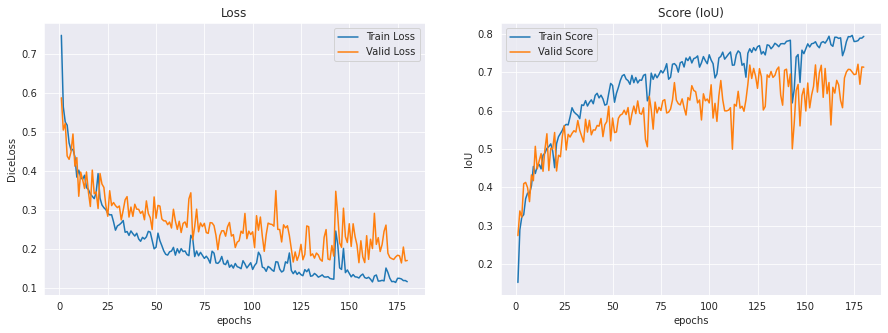

In [59]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,181), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,181), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,181), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,181), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

## **Validating The Model**

In [60]:
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [61]:
def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in val_loader:
        data = torch.autograd.Variable(data, volatile=True).cuda()
        mask = torch.autograd.Variable(mask, volatile=True).cuda()
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


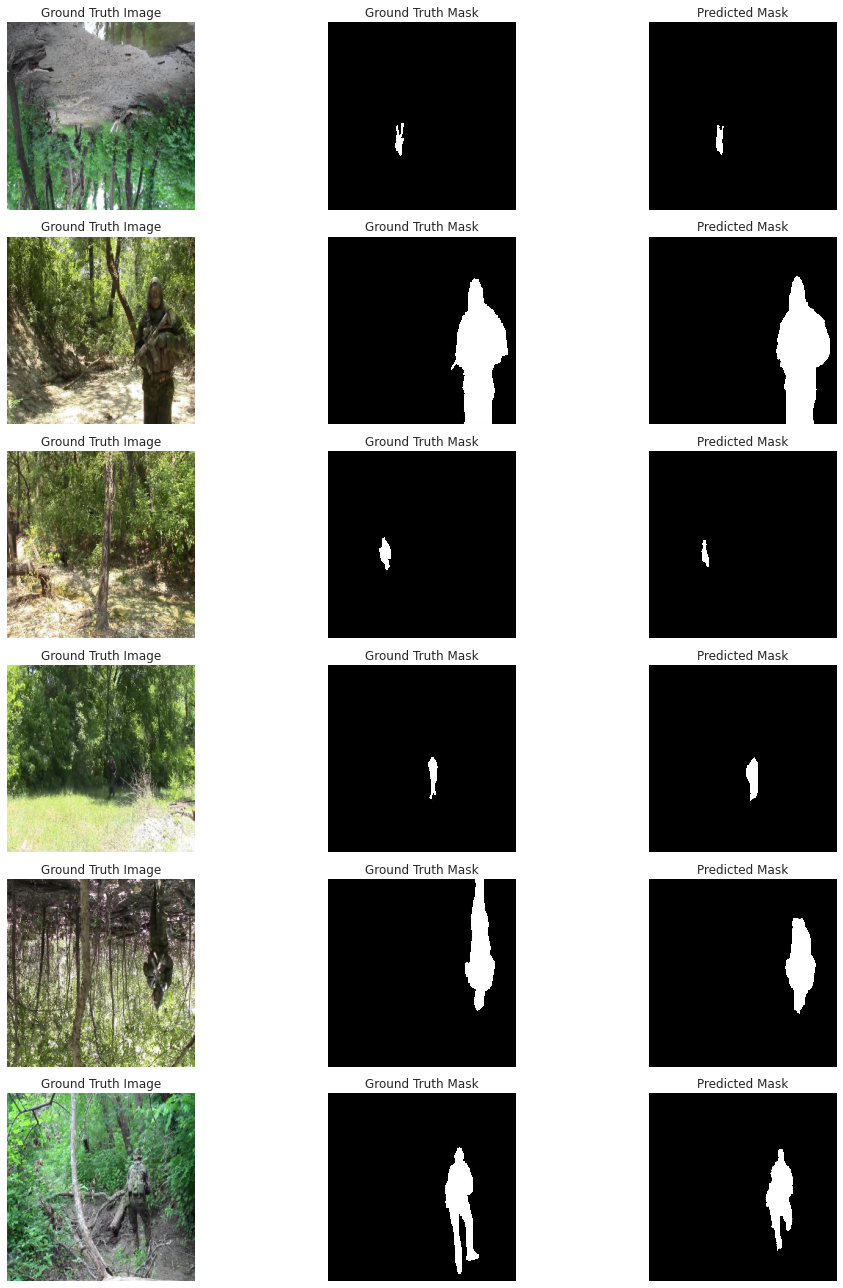

In [62]:
visualize_predict(model, 6)

## **Checking Test Predictions**

In [1]:
TEST_PATH = '/content/drive/MyDrive/carvana6/test_data'
test_dataset = DataLoaderSegmentation(TEST_PATH, transform=get_train_transform())

NameError: ignored

In [26]:
image, mask = test_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [27]:
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

In [ ]:
def format_image(img):
    """
    Function to de-standardize the image
    arg: Input Image
    returns: De-standardized image
    """
    img = np.array(np.transpose(img, (1,2,0)))
    mean = np.array((0.485, 0.456, 0.406))
    std = np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img

def format_mask(mask):
    """
    Function to reshape the mask
    """
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

In [29]:
def visualize_test_dataset(n_images, predict=None):
  """
  Function to visualize images and masks
  """
  maxRange = train_dataset.__len__()
  images = random.sample(range(0, maxRange), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = test_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
    ax[i, 0].set_title("Ground Truth Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()

[19, 4, 20]


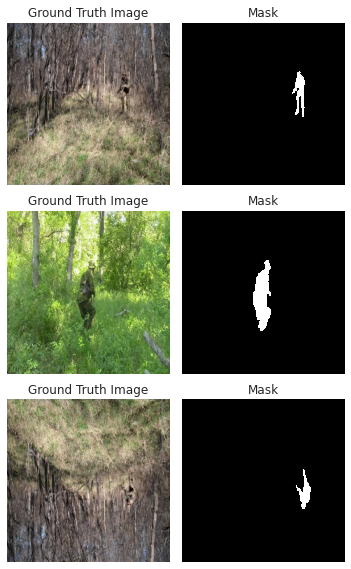

In [31]:
visualize_test_dataset(3)

In [34]:
def visualize_test_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in test_loader:
        data = torch.autograd.Variable(data, volatile=True).cuda()
        mask = torch.autograd.Variable(mask, volatile=True).cuda()
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


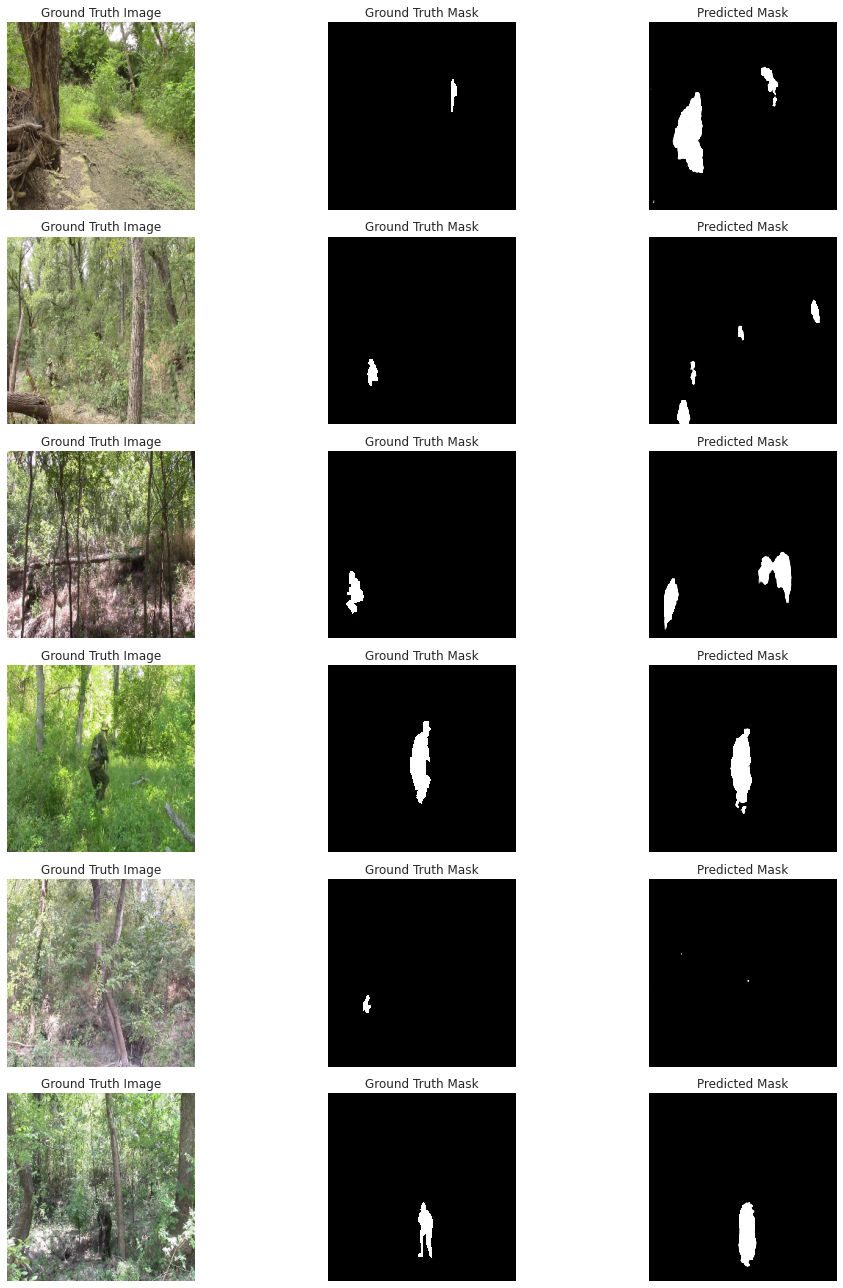

In [35]:
visualize_test_predict(model, 6)

In [40]:
import os
import shutil

source_folder = r"/content/model_weight/"
destination_folder = r"/content/drive/MyDrive/carvana6/model_weight/"

# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name

    print(source)
    print(destination)

    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)
        print('copied', file_name)

    else:
      print('__')

/content/model_weight/bestmodel.pt
/content/drive/MyDrive/carvana6/model_weight/bestmodel.pt
copied bestmodel.pt
/content/model_weight/chkpoint_
/content/drive/MyDrive/carvana6/model_weight/chkpoint_
copied chkpoint_
